In [1]:
# data processing
import numpy as np
import pandas as pd
import networkx as nx

# plotting
import matplotlib.pyplot as plt

# PySR
# import pysr
# pysr.install()
from pysr import PySRRegressor

# utils
import warnings

# Creating our graph data

In [2]:
# load bike dataset from datasets folder
bike_data = pd.read_csv('datasets/MontrealBikeLane.csv')
# removing columns that have any missing data
# bike_data = bike_data.dropna(axis=1)
bike_data["Date"] = pd.to_datetime(bike_data["Date"], format="%d/%m/%Y")
bike_data = bike_data.sort_values(by=['Date', 'Time'], ascending=True)
bike_data = bike_data.reset_index(drop=True)
bike_data.head(12)

,Date,Time,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,2015-01-01,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,2015-01-02,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,2015-01-03,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,2015-01-04,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,2015-01-05,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10
5,2015-01-06,00:00,101,0,1,1,62.0,153,38,3,...,NaN,1,12,64,23,NaN,29,121,91,5
6,2015-01-07,00:00,121,15,5,3,38.0,144,35,1,...,NaN,11,24,40,3,NaN,5,120,63,4
7,2015-01-08,00:00,70,0,36,0,39.0,139,36,4,...,NaN,38,67,21,7,NaN,1,83,78,2
8,2015-01-09,00:00,88,3,5,0,55.0,135,26,12,...,NaN,26,63,14,10,NaN,1,166,79,1
9,2015-01-10,00:00,29,7,6,0,24.0,70,17,3,...,NaN,15,29,0,7,NaN,0,32,41,1


<Axes: xlabel='Date'>

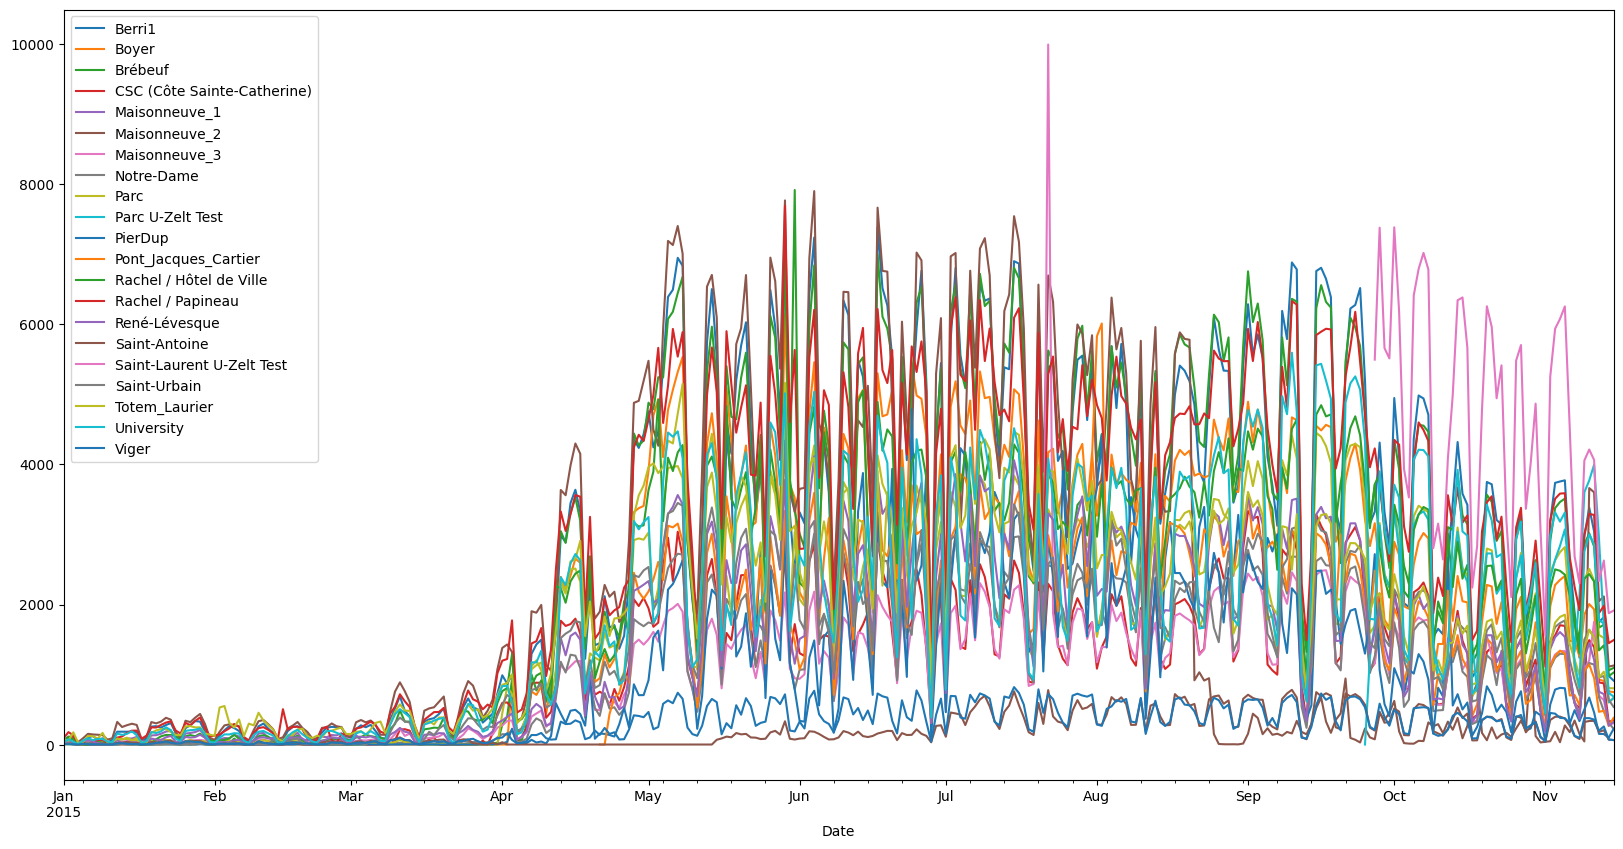

In [3]:
bike_data.loc[:, [col not in  ["Time"] for col in bike_data.columns]].plot(x="Date", figsize=(20,10))

In [4]:
# normalizing with min-max with scikit-learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
target_columns = [col for col in bike_data.columns if col not in ['Date', 'Time']]
bike_data.loc[:, target_columns] = scaler.fit_transform(bike_data.loc[:, target_columns])
bike_data.head(12)

,Date,Time,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,2015-01-01,00:00,0.006507,0.001950,0.000546,0.005099,0.116751,0.005947,0.001301,0.005272,...,NaN,0.007322,0.011183,0.005828,0.003841,NaN,0.003915,0.011271,0.002683,0.007317
1,2015-01-02,00:00,0.008811,0.001138,0.000683,0.004499,0.101523,0.014045,0.001902,0.002965,...,NaN,0.013761,0.022367,0.007771,0.016645,NaN,0.002533,0.007190,0.012701,0.004878
2,2015-01-03,00:00,0.009353,0.001138,0.000410,0.002100,0.101523,0.013286,0.002803,0.003954,...,NaN,0.008964,0.016385,0.008014,0.006402,NaN,0.003224,0.029926,0.006082,0.006098
3,2015-01-04,00:00,0.000000,0.000163,0.002868,0.000000,0.000000,0.004176,0.002102,0.000329,...,NaN,0.000757,0.000780,0.001457,0.001280,NaN,0.000230,0.000000,0.000000,0.000000
4,2015-01-05,00:00,0.004338,0.000000,0.000273,0.000000,0.086294,0.011135,0.001301,0.000329,...,NaN,0.000000,0.000000,0.011899,0.025608,NaN,0.000000,0.004081,0.008945,0.012195
5,2015-01-06,00:00,0.012336,0.000000,0.000137,0.000300,0.263959,0.019107,0.003003,0.000988,...,NaN,0.000126,0.000910,0.015542,0.029449,NaN,0.006679,0.019627,0.015206,0.006098
6,2015-01-07,00:00,0.015047,0.002438,0.000683,0.000900,0.142132,0.017968,0.002702,0.000329,...,NaN,0.001389,0.002471,0.009713,0.003841,NaN,0.001152,0.019433,0.010197,0.004878
7,2015-01-08,00:00,0.008133,0.000000,0.004917,0.000000,0.147208,0.017335,0.002803,0.001318,...,NaN,0.004797,0.008062,0.005100,0.008963,NaN,0.000230,0.012243,0.012880,0.002439
8,2015-01-09,00:00,0.010573,0.000488,0.000683,0.000000,0.228426,0.016829,0.001802,0.003954,...,NaN,0.003282,0.007542,0.003400,0.012804,NaN,0.000230,0.028372,0.013059,0.001220
9,2015-01-10,00:00,0.002576,0.001138,0.000819,0.000000,0.071066,0.008604,0.000901,0.000988,...,NaN,0.001894,0.003121,0.000000,0.008963,NaN,0.000000,0.002332,0.006261,0.001220


<Axes: xlabel='Date'>

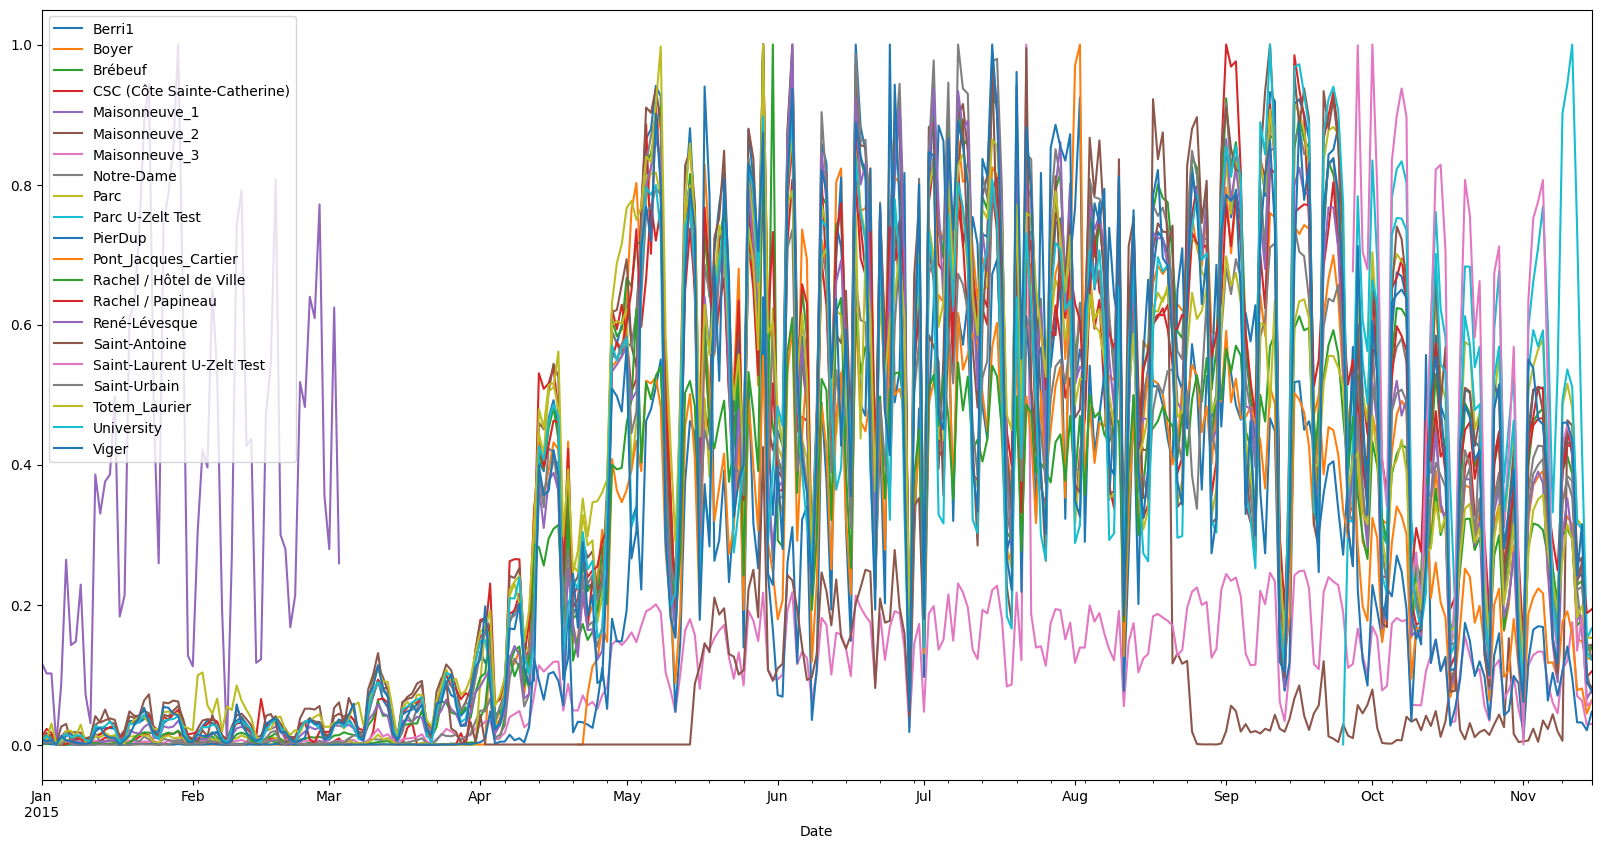

In [5]:
bike_data.loc[:, [col not in  ["Time"] for col in bike_data.columns]].plot(x="Date", figsize=(20,10))

In [6]:
# create dictionary with column names and index order starting from 0 excluding Date and Time
# this is because we want to predict the number of bikes in the future
# and we don't want to include the future in our features
node_encoder = {}
for i, col in enumerate(bike_data.columns):
    if col != 'Date' and col != 'Time':
        node_encoder[col] = i - 2
node_encoder

{'Berri1': 0,
 'Boyer': 1,
 'Brébeuf': 2,
 'CSC (Côte Sainte-Catherine)': 3,
 'Maisonneuve_1': 4,
 'Maisonneuve_2': 5,
 'Maisonneuve_3': 6,
 'Notre-Dame': 7,
 'Parc': 8,
 'Parc U-Zelt Test': 9,
 'PierDup': 10,
 'Pont_Jacques_Cartier': 11,
 'Rachel / Hôtel de Ville': 12,
 'Rachel / Papineau': 13,
 'René-Lévesque': 14,
 'Saint-Antoine': 15,
 'Saint-Laurent U-Zelt Test': 16,
 'Saint-Urbain': 17,
 'Totem_Laurier': 18,
 'University': 19,
 'Viger': 20}

In [7]:
# open the BikeLanesConnections.txt and extract the connections between the nodes via links in the PyG format.
# Use the previous function of node enconder to transforms bike lanes name to the desired encoded format.
# Path: BikeLanesConnections.txt, format X <-> Y
# X and Y are the names of the bike lanes
# X <-> Y means that X and Y are connected
def get_edge_connections():
    with open('BikeLanesConnections.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [x.split(' <-> ') for x in content]
    content = [[node_encoder[x[0]], node_encoder[x[1]]] for x in content]
    content = np.ascontiguousarray(np.array(content).transpose())
    return content

# create function to get edge and node index
def get_node_and_edge_index(bike_data):
    node_index = list(
        range(0, len(
                    [col for col in bike_data.columns if col not in ["Date", "Time"]]
                )
        )
    )
    
    
    edge_index = get_edge_connections()

    return node_index, edge_index


# create function to create a Data object in Pynp Geometric for each row
def get_all_nodes_features_and_labels(dataframe, k = 12):
    """
    Each feature vector from the nodes is the vector of lagged values of the
    bike count from previous k Date. It assumes the dataframe is ordered by Date and Time.
    """
    all_nodes_features = []
    all_nodes_labels = []
    for j in [col for col in dataframe.columns if col not in ["Date", "Time"]]:
        node_features_across_dates = []
        node_labels_across_dates = []
        for i in range(dataframe.shape[0]):
            # get the previous k values
            lagged_values = dataframe[j].iloc[i-k:i].values
            label_value = np.array(dataframe[j].iloc[i])
            # if there are not k previous values, skip the row
            if len(lagged_values) == k:
                node_features_across_dates.append(lagged_values)
                node_labels_across_dates.append(label_value)
        all_nodes_features.append(node_features_across_dates)
        all_nodes_labels.append(node_labels_across_dates)

    return all_nodes_features, all_nodes_labels

# showcasing one graph
node_index, edge_index = get_node_and_edge_index(bike_data)
all_nodes_features, all_nodes_labels = get_all_nodes_features_and_labels(bike_data, k=7)
print(all_nodes_features[0][0], all_nodes_labels[0][0])

[0.00650671 0.00881117 0.0093534  0.         0.00433781 0.01233564
 0.01504677] 0.008133387555917039


In [8]:
class GraphData():
    def __init__(self, x, y, edge_index) -> None:
        self.x = x
        self.num_nodes = x.shape[0]
        self.y = y
        self.edge_index = edge_index
    
    def __repr__(self) -> str:
        return f"GraphData(x={self.x.shape}, y={self.y.shape}, edge_index={self.edge_index.shape})"
    
    def to_networkx(self):
        G = nx.Graph()
        G.add_nodes_from(range(self.x.shape[0]))
        G.add_edges_from(self.edge_index.transpose())
        return G

graph_list = []
for date_index in range(len(all_nodes_features[0])):
    node_features = [all_nodes_features[i][date_index] for i in range(len(all_nodes_features))]
    node_labels = [all_nodes_labels[i][date_index] for i in range(len(all_nodes_labels))]
    node_features = np.stack(node_features)
    node_labels = np.stack(node_labels)
    graph = GraphData(x=node_features, y=node_labels, edge_index=edge_index)
    graph_list.append(graph)
print(len(graph_list))
graph = graph_list[0]
graph

312


GraphData(x=(21, 7), y=(21,), edge_index=(2, 32))

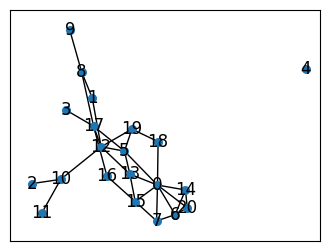

In [9]:
def plot_graph(g):
    plt.figure(figsize=(4, 3))
    nx.draw_networkx(g, node_size=30, arrows=False, node_color=None)
    plt.show() 
    
    
g = graph.to_networkx()
plot_graph(g)

In [10]:
class RandomNodeSplitter:
    def __init__(self, train_val_test_ratio = [0.8, 0.1, 0.1]):
        self.train_val_test_ratio = train_val_test_ratio
        self.has_mask = False
    

    def setup_split(self, num_nodes) -> None:
        train_mask = np.zeros(num_nodes, dtype=bool)
        val_mask = np.zeros(num_nodes, dtype=bool)
        test_mask = np.zeros(num_nodes, dtype=bool)

        # randomly assign nodes to train, val, test with permutation
        train_ratio = self.train_val_test_ratio[0]
        train_n = int(num_nodes * train_ratio)
        val_ratio = self.train_val_test_ratio[1]
        val_n = int(num_nodes * val_ratio)

        permutation = np.random.permutation(num_nodes)
        train_mask[permutation[:train_n]] = 1
        val_mask[permutation[train_n:train_n+val_n]] = 1
        test_mask[permutation[train_n+val_n:]] = 1

        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

        self.has_mask = True


    def __call__(self, graph, save_mask=True):
        if self.has_mask is False or save_mask is False:
            print("Generating new random split.")
            self.setup_split(graph.num_nodes)

        # assign masks to graph
        graph.train_mask = self.train_mask
        graph.val_mask = self.val_mask
        graph.test_mask = self.test_mask

        return graph

split = RandomNodeSplitter()
graph = split(graph)
graph

Generating new random split.


GraphData(x=(21, 7), y=(21,), edge_index=(2, 32))

In [11]:
# using loader to get the full dataset but split into train, val, test
split = RandomNodeSplitter()
split.setup_split(graph.num_nodes)
graph_list = [split(graph) for graph in graph_list]
graph = graph_list[0]
graph

GraphData(x=(21, 7), y=(21,), edge_index=(2, 32))

In [22]:
def get_all_related_nodes(target_node:int, edge_index:np.ndarray) -> list[int]:
    target_edges_pairs = []
    for edge_pair in edge_index.transpose():
        if target_node in edge_pair:
            target_edges_pairs.append(edge_pair)
    target_edges_pairs = np.array(target_edges_pairs)
    target_edges = np.unique(target_edges_pairs.flatten())
    if len(target_edges) == 0:
        return [target_node]
    else:
        return target_edges.tolist()

# for each node, create a dataframe of the features and labels
# the size of the columns will vary depending on the number of how many other nodes are connected to it
# the number of rows will be the number of dates
# the number of dataframes will be the number of nodes
def get_dataframes_per_node_from_graph_list(graph_list) -> list[pd.DataFrame]:
    dataframes = []
    graph = graph_list[0]
    for node in range(graph.num_nodes):
        data_per_date = []
        # get the target edges for the node
        all_related_nodes = get_all_related_nodes(node, graph.edge_index)
        for graph in graph_list:
            # get the features and labels for the node
            features = graph.x[all_related_nodes, :]
            size_of_features_per_node = features.shape[1]
            labels = graph.y[node]
            # transform the features into a flatten vector
            features = features.transpose().flatten()
            # add the labels to the end of the vector
            data = np.append(features, labels)
            data_columns = [
                f"node_{i}_lag_{j}"
                for i in all_related_nodes
                for j in range(size_of_features_per_node)
            ] + ["label"]
            # create a dataframe
            data_series = pd.Series(
                data=data,
                index=data_columns
            )
            data_series["node"] = node

            data_per_date.append(data_series)
        dataframes.append(pd.concat(data_per_date, axis=1).transpose())
    return dataframes
            
dataframes_per_node = get_dataframes_per_node_from_graph_list(graph_list)
dataframes_per_node[5]

,node_0_lag_0,node_0_lag_1,node_0_lag_2,node_0_lag_3,node_0_lag_4,node_0_lag_5,node_0_lag_6,node_5_lag_0,node_5_lag_1,node_5_lag_2,...,node_17_lag_6,node_19_lag_0,node_19_lag_1,node_19_lag_2,node_19_lag_3,node_19_lag_4,node_19_lag_5,node_19_lag_6,label,node
0,0.006507,0.005947,0.007322,0.011183,0.003915,0.002683,0.008811,0.014045,0.013761,0.022367,...,0.006679,0.015206,0.015047,0.017968,0.001389,0.002471,0.001152,0.010197,0.017335,5.0
1,0.008811,0.014045,0.013761,0.022367,0.002533,0.012701,0.009353,0.013286,0.008964,0.016385,...,0.001152,0.010197,0.008133,0.017335,0.004797,0.008062,0.000230,0.012880,0.016829,5.0
2,0.009353,0.013286,0.008964,0.016385,0.003224,0.006082,0.000000,0.004176,0.000757,0.000780,...,0.000230,0.012880,0.010573,0.016829,0.003282,0.007542,0.000230,0.013059,0.008604,5.0
3,0.000000,0.004176,0.000757,0.000780,0.000230,0.000000,0.004338,0.011135,0.000000,0.000000,...,0.000230,0.013059,0.002576,0.008604,0.001894,0.003121,0.000000,0.006261,0.011008,5.0
4,0.004338,0.011135,0.000000,0.000000,0.000000,0.008945,0.012336,0.019107,0.000126,0.000910,...,0.000000,0.006261,0.007591,0.011008,0.002525,0.002861,0.000000,0.004651,0.040617,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.507930,0.003923,0.313344,0.465410,0.399585,0.568515,0.510235,0.034291,0.306274,0.466190,...,0.345463,0.492308,0.457503,0.463242,0.307411,0.427568,0.377246,0.535957,0.455650,5.0
308,0.510235,0.034291,0.306274,0.466190,0.408107,0.591592,0.352853,0.022143,0.268905,0.347204,...,0.377246,0.535957,0.411278,0.455650,0.293902,0.425878,0.353293,0.510555,0.258889,5.0
309,0.352853,0.022143,0.268905,0.347204,0.277522,0.398569,0.253355,0.043148,0.217018,0.292068,...,0.353293,0.510555,0.236004,0.258889,0.169802,0.243433,0.221096,0.316816,0.267367,5.0
310,0.253355,0.043148,0.217018,0.292068,0.212575,0.206977,0.166734,0.018854,0.164247,0.249025,...,0.221096,0.316816,0.245086,0.267367,0.178765,0.256827,0.225242,0.307871,0.140453,5.0


# GraphGP

Our approach is going to be done via creating 17 models, one for each bike lane, and then using the models to predict the number of trips for each bike lane. We will then compare the predictions to the actual number of trips.

In [27]:
warnings.filterwarnings("ignore")
best_equation_per_node_dict = {}
for node_index in range(len(dataframes_per_node)):
    print("NODEX INDEX: ", node_index)
    node_dataframe = dataframes_per_node[node_index]
    print(node_dataframe.shape)
    print(node_dataframe.isna().mean()[node_dataframe.isna().mean() > 0])
    print(node_dataframe.columns)
    node_dataframe = node_dataframe.dropna(axis=0)
    X = node_dataframe.iloc[:, :-2]
    y = node_dataframe.iloc[:, -2]

    model = PySRRegressor(
        niterations=40,  # < Increase me for better results
        binary_operators=["+", "-", "*", "/"],
        unary_operators=[
            "exp",
            "log",
            #"pow",
            "inv(x) = 1/x",
            # ^ Custom operator (julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        loss="L2DistLoss()",
        # ^ Custom loss function (julia syntax)
        maxsize=20,
        model_selection="best",
        select_k_features=10,
        equation_file=f"datasets/GP_hall_of_fame/node_{node_index}.csv",
        verbosity=False,
        progress=False,
    )
    model.fit(X, y)
    print()
    print(model.get_best().equation)
    best_equation_per_node_dict[node_index] = model.get_best().equation
    print()

NODEX INDEX:  0
(312, 65)
Series([], dtype: float64)
Index(['node_0_lag_0', 'node_0_lag_1', 'node_0_lag_2', 'node_0_lag_3',
       'node_0_lag_4', 'node_0_lag_5', 'node_0_lag_6', 'node_5_lag_0',
       'node_5_lag_1', 'node_5_lag_2', 'node_5_lag_3', 'node_5_lag_4',
       'node_5_lag_5', 'node_5_lag_6', 'node_6_lag_0', 'node_6_lag_1',
       'node_6_lag_2', 'node_6_lag_3', 'node_6_lag_4', 'node_6_lag_5',
       'node_6_lag_6', 'node_7_lag_0', 'node_7_lag_1', 'node_7_lag_2',
       'node_7_lag_3', 'node_7_lag_4', 'node_7_lag_5', 'node_7_lag_6',
       'node_13_lag_0', 'node_13_lag_1', 'node_13_lag_2', 'node_13_lag_3',
       'node_13_lag_4', 'node_13_lag_5', 'node_13_lag_6', 'node_14_lag_0',
       'node_14_lag_1', 'node_14_lag_2', 'node_14_lag_3', 'node_14_lag_4',
       'node_14_lag_5', 'node_14_lag_6', 'node_15_lag_0', 'node_15_lag_1',
       'node_15_lag_2', 'node_15_lag_3', 'node_15_lag_4', 'node_15_lag_5',
       'node_15_lag_6', 'node_18_lag_0', 'node_18_lag_1', 'node_18_lag_2',


In [28]:
best_equation_per_node_dict

{0: '((node_5_lag_1 + node_20_lag_5) * 0.5427274)',
 1: '(node_12_lag_4 / (0.55649316 + node_12_lag_6))',
 2: '((node_10_lag_5 + node_2_lag_0) * 0.48978716)',
 3: '((node_17_lag_5 + node_3_lag_0) * 0.4907466)',
 4: '((node_4_lag_6 + node_4_lag_0) * 0.50137573)',
 5: '((node_19_lag_2 + node_0_lag_1) * 0.48832163)',
 6: '(node_20_lag_3 / (exp(node_20_lag_3 * exp(node_20_lag_4)) - (node_0_lag_4 * node_0_lag_3)))',
 7: '((node_15_lag_5 + node_0_lag_0) * 0.4717224)',
 8: '(node_1_lag_1 / (exp(node_1_lag_3) - node_17_lag_6))',
 9: '(inv(((node_8_lag_4 / node_8_lag_0) + exp(node_9_lag_4)) + node_8_lag_2) + (node_9_lag_6 * node_8_lag_2))',
 10: '((node_2_lag_2 + node_12_lag_5) * 0.4781184)',
 11: '(exp(node_11_lag_6) * 0.25533712)',
 12: '((node_1_lag_5 + node_19_lag_4) / 2.503271)',
 13: '((node_15_lag_5 + node_0_lag_3) * 0.49116966)',
 14: '((node_0_lag_3 + node_20_lag_5) / 2.026274)',
 15: '((node_0_lag_3 + (node_16_lag_5 * node_7_lag_2)) / exp(node_0_lag_3))',
 16: '(node_15_lag_0 - (node_